# Under- and overfitting, model selection

## Preliminaries

In the first set of exercises you had to implement the training and evaluation of the linear regression and $k$-NN methods from scratch in order to practice your `numpy` skills. From this set of exercises onward, you can use the implementations provided in `scikit-learn` or other higher-level libraries. We start this set of exercises by demonstrating some of the features of `scikit-learn`.

For example, implementation of linear regression model fitting with an analytical solution for the parameters is provided by the class `sklearn.linar_model.LinearRegression`. You can train a linear regression model in the following way:

In [2]:
import numpy as np
from sklearn import datasets, linear_model

# load the diabetes dataset
diabetes = datasets.load_diabetes()

# use only one feature
X = diabetes.data[:, np.newaxis, 2]
y = diabetes.target

# split the data into training/testing sets
X_train = X[:-20]
X_test = X[-20:]

# split the targets into training/testing sets
y_train = y[:-20]
y_test = y[-20:]

# create linear regression object
model = linear_model.LinearRegression()

# train the model using the training dataset
model.fit(X_train, y_train)

LinearRegression()

Let's visualize the training dataset and the learned regression model.

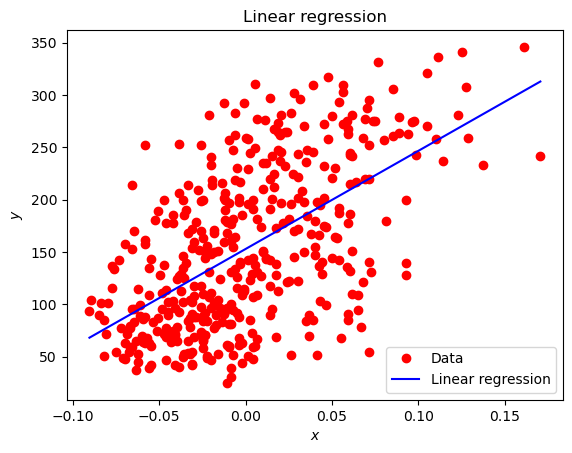

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(X_train, y_train, 'r.', markersize=12)
X_edge = np.array([np.min(X_train, 0), np.max(X_train, 0)])
plt.plot(X_edge, model.predict(X_edge), 'b-')
plt.legend(('Data', 'Linear regression'), loc='lower right')
plt.title('Linear regression')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

Once trained, the model can be used to make predictions on the test data:

In [4]:
# Make predictions using the testing dataset
prediction = model.predict(X_test)

The next step (not shown here) is to evaluate the performance of the trained model.

Note that the `scikit-learn` interface works by first initializing an object from the class that implements the machine learning model (linear regression in this case) and then fitting the initialized model using the data in the training set. Finally, the trained (fitted) model can be used to make predictions on unseen data. In fact, all models implemented in this library follow the same *initialize-fit-predict* programming interface. For example, a $k$-NN classifier can be trained in the following way:

In [5]:
from sklearn.model_selection import train_test_split
from sklearn import datasets, neighbors

breast_cancer = datasets.load_breast_cancer()

X = breast_cancer.data
y = breast_cancer.target

# make use of the train_test_split() utility function instead
# of manually dividing the data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=40)

# initialize a 3-NN classifier
model = neighbors.KNeighborsClassifier(n_neighbors=3)

# train the model using the training dataset
model.fit(X_train, y_train)

# make predictions using the testing dataset
prediction = model.predict(X_test)

Note that the features in the breast cancer dataset have different scales (some have on average very small absolute values, and some very large), which means that the distance metric used by $k$-NN will me dominated by the features with large values. You can use any of the number of feature transformation methods implemented in `scikit-learn` to scale the features. For example, you can use the `sklearn.preprocessing.StandardScaler` method to transform all features to a have a zero mean and unit variance:

In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)

The scaler has its own parameters which are the means and standard deviations of the features estimated from the training set. If you train a model with the scaled features, you will have to remember to also apply the scaling transformation every time you make a prediction on new unseen and unscaled data. This is somewhat prone to error. One option for making the code more robust is to create a processing pipeline that includes the scaling and $k$-NN models in a sequence:

In [7]:
from sklearn.pipeline import Pipeline

knn = neighbors.KNeighborsClassifier(n_neighbors=3)

model = Pipeline([
                 ("scaler", scaler),
                 ("knn", knn)
                ])

# train the model using the training dataset
model.fit(X_train, y_train)

# make predictions using the testing dataset
prediction = model.predict(X_test)


If you are curious, more information about the design of the `scikit-learn` application programming interface (API) can be found [in this paper](https://arxiv.org/pdf/1309.0238.pdf). 

## Exercises

### Bias-variance decomposition

Show that the mean squared error of the estimate of a parameter can be decomposed into an expression that includes both the bias and variance (Eq. 5.53-5.54 in "Deep learning" by Goodfellow et al.). 

$$MSE(\hat\theta)=E((\hat\theta-\theta)^2)$$
$$=E[(\hat\theta-E(\hat\theta)+E(\hat\theta)-\theta)^2]$$
$$=E[(\hat\theta-E(\hat\theta))^2+2((\hat\theta-E(\hat\theta))(E(\hat\theta)-\theta))+(E(\hat\theta)-\theta)^2)$$
$$=E[(\hat\theta=E(\hat\theta)^2]+2E[(\hat\theta-E(\hat\theta))(E(\hat\theta)-\theta)]+E[(E(\hat\theta)-\theta)^2]$$
$$=E[(\hat\theta-E(\hat\theta))^2]+2(E(\hat\theta)-\theta)E(\hat\theta)-E(\hat\theta))+E[(E(\hat\theta)-\theta)^2]$$

Since $E(\theta)-E(\theta)=0$ it follows:

$$=E[(\hat\theta-E(\hat\theta))^2]+E[(E(\hat\theta)-\theta)^2]$$

$$=Var(\hat\theta)+Bias(\hat\theta,\theta)^2$$

### Polynomial regression

For this exercise we will be using generated data to better show the effects of the different polynomial orders.
The data is created using the make_polynomial_regression function.

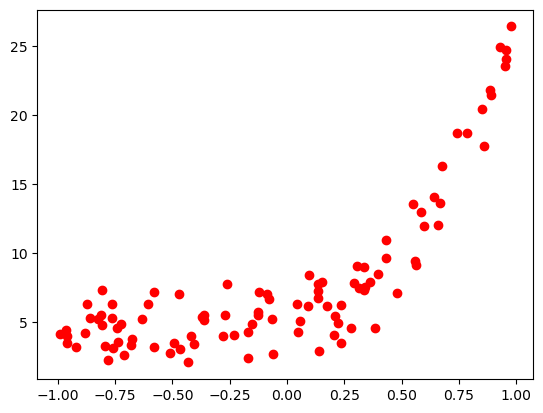

In [8]:
%matplotlib inline

def generate_dataset(n=100, degree=1, noise=1, factors=None):
    # Generates a dataset by adding random noise to a randomly
    # generated polynomial function.
    
    x = np.random.uniform(low=-1, high=1, size=n)
    
    factors = np.random.uniform(0, 10, degree+1)
    
    y = np.zeros(x.shape)
    
    for idx in range(degree+1):
        y += factors[idx] * (x ** idx)

    # add noise
    y += np.random.normal(-noise, noise, n)
    
    return x, y

# load generated data
np.random.seed(0)

X, y = generate_dataset(n=100, degree=4, noise=1.5)

plt.plot(X, y, 'r.', markersize=12)

Implement polynomial regression using the `sklearn.preprocessing.PolynomialFeatures` transformation. Using the `sklearn.grid_search.GridSearchCV` class, perform a grid search of the polynomial order hyperparameter space with cross-validation and report the performance on an independent test set.

Plot a learning curve that show the validation accuracy as a function of the polynomial order. 

Best Polynomial Degree: 3
Best MSE: 3.213966714701596


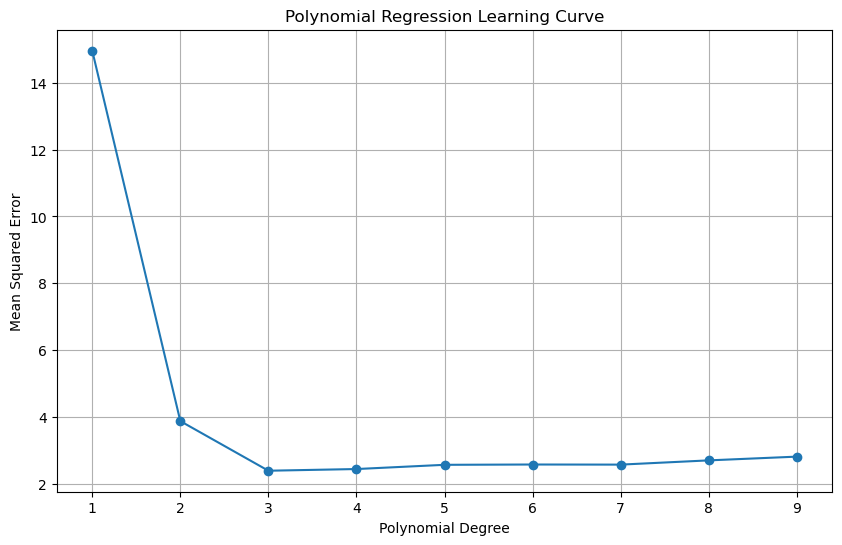

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline  # Import make_pipeline

np.random.seed(0)
X, y = generate_dataset(n=100, degree=4, noise=1.5)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the pipeline with PolynomialFeatures and LinearRegression
model = make_pipeline(PolynomialFeatures(include_bias=False), LinearRegression())

# Create a parameter grid for polynomial degree
param_grid = {'polynomialfeatures__degree': np.arange(1, 10)}

# Initialize the GridSearchCV object
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)

# Fit the model on the training data
grid_search.fit(X_train.reshape(-1, 1), y_train)

# Get the best polynomial degree
best_degree = grid_search.best_params_['polynomialfeatures__degree']

# Evaluate on the test set
y_pred = grid_search.predict(X_test.reshape(-1, 1))
test_mse = mean_squared_error(y_test, y_pred)

# Print the best degree and test performance
print(f'Best Polynomial Degree: {best_degree}')
print(f'Best MSE: {test_mse}')

# Plot learning curve
degrees = np.arange(1, 10)
mean_scores = -grid_search.cv_results_['mean_test_score']

plt.figure(figsize=(10, 6))
plt.plot(degrees, mean_scores, marker='o')
plt.title('Polynomial Regression Learning Curve')
plt.xlabel('Polynomial Degree')
plt.ylabel('Mean Squared Error')
plt.grid(True)
plt.show()

## <p><font color='#770a0a'>Which models have a high bias, and which models have high variance? Motivate your answer.</font><p>
    
## Answer: 
    
High Bias Models which represents underfitting are defined by models with low polynomial degrees for example 1 or 2. Using a polynomial degree equal to 1 which means a straight line or a polynomial degree of 2 which means a simple curve to fit the data may not capture the data accurately. As the data has a certain degree of complexity, these models would be way to simple to represent everything, resulting in underfitting. Low polynomial models however do tend to show a low variance as they are not flexible and thus have not learned the noise in the training data.Therefore, they perform poorly on both the training and the test set in terms of bias, they are far away from 'the truth'. 
    
On the other side, models with very high polynomial degrees like 6,7,8,9 are likely to have a high variance, fitting the data extremely well, even to the extent of fitting the noise. Therefore, they tend to perform exceptionally well on the training data but poorly on new, unseen data which is represented by the test set. These models with high variance are poorly generalizable.  
    
 In conclusion, a model with moderate complexity ( a degree around 3 or 4) is likely to strike the best balance between bias and variance for this specific dataset.
    

Repeat this experiment, this time using the diabetes dataset instead of the generated data.

(89,)
Best Polynomial Degree: 1
Test MSE: 2900.1936284934827
[3.14301531e+03 4.05325417e+03 6.15768677e+06 2.52579088e+05
 1.93382452e+05 1.06266796e+06 5.57861108e+06 2.46745435e+07
 5.22211468e+08]


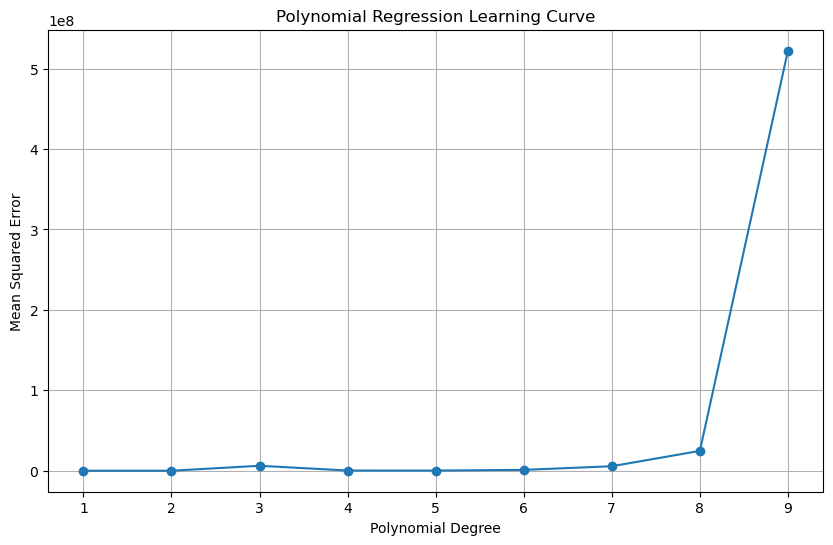

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.datasets import load_diabetes
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Load diabetes dataset
diabetes = load_diabetes()
X, y = diabetes.data, diabetes.target  # Use all features

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the pipeline with the standardscaler with the mean around 0 for every feature and
# the PolynomialFeatures and LinearRegression
model = make_pipeline(StandardScaler(with_mean=False),PolynomialFeatures(include_bias=False), LinearRegression())

# Create a parameter grid for polynomial degree
param_grid = {'polynomialfeatures__degree': np.arange(1, 10)}

# Initialize the GridSearchCV object
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)

# Fit the model on the training data
grid_search.fit(X_train, y_train)

# Get the best polynomial degree
best_degree = grid_search.best_params_['polynomialfeatures__degree']

# Evaluate on the test set
y_pred = grid_search.predict(X_test)
test_mse = mean_squared_error(y_test, y_pred)
print(y_pred.shape)

# Print the best degree and test performance
print(f'Best Polynomial Degree: {best_degree}')
print(f'Test MSE: {test_mse}')

# Plot learning curve
degrees = np.arange(1, 10)
mean_scores = -grid_search.cv_results_['mean_test_score'] # get all the MSE scores for the different hyperparameters. 
print(mean_scores)

plt.figure(figsize=(10, 6))
plt.plot(degrees, mean_scores, marker='o')
plt.title('Polynomial Regression Learning Curve')
plt.xlabel('Polynomial Degree')
plt.ylabel('Mean Squared Error')
plt.grid(True)
plt.show()

### ROC curve analysis
A common method to evaluate binary classifiers is the receiver operating characteristic (ROC) curve. Similar to the week one practicals, implement a $k$-NN classifier on the breast cancer dataset, however, his time use the $k$-NN pipeline from the preliminary. Train the model for different values of $k$ and evaluate their respective performance with an ROC curve, use the `sklearn.metrics.roc_curve` function.

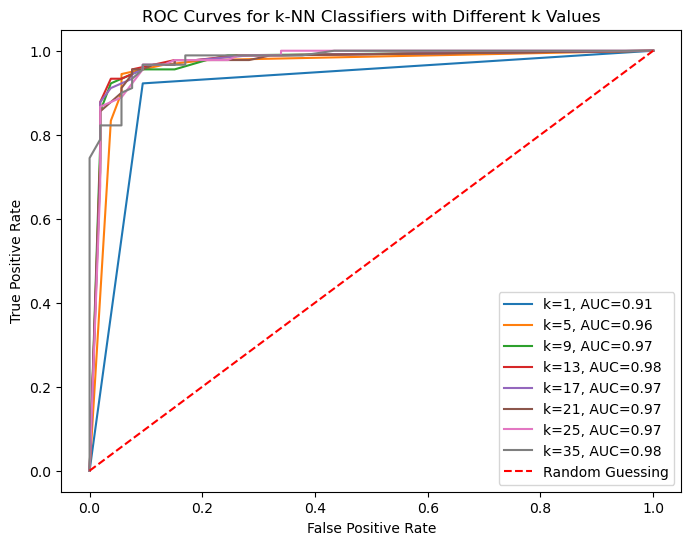

In [15]:
from sklearn import metrics

breast_cancer = datasets.load_breast_cancer()

X = breast_cancer.data
y = breast_cancer.target

# make use of the train_test_split() utility function instead
# of manually dividing the data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=40)

# Define a list of k values for k-NN classifiers
k_values = [1, 5, 9,13,17,21,25,35]

# Create empty lists to store ROC curve data
fpr_list = []
tpr_list = []
auc_list = []

# Loop through different k values
for k in k_values:
    # Initialize a k-NN classifier
    model = neighbors.KNeighborsClassifier(n_neighbors=k)

    # Train the model using the training dataset
    model.fit(X_train, y_train)

    # Predict probabilities for the positive class (class 1)
    y_probs = model.predict_proba(X_test)[:, 1]

    # Compute ROC curve
    fpr, tpr, _ = metrics.roc_curve(y_test, y_probs)

    # Compute AUC (Area Under the Curve)
    auc = metrics.auc(fpr, tpr)

    # Append ROC curve data and AUC to the lists
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    auc_list.append(auc)

# Plot ROC curves for different k values
plt.figure(figsize=(8, 6))
for i, k in enumerate(k_values):
    plt.plot(fpr_list[i], tpr_list[i], label=f'k={k}, AUC={auc_list[i]:.2f}')
    
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Random Guessing')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for k-NN Classifiers with Different k Values')
plt.legend()
plt.show()

### conclusion
The model has the worst performance with k=1 as it lies closest to the diagonal. The diagonal represents the rates you would get from randomly guessing. The further a model's ROC is from this line the beter it is able to predict. For neighbours greater than 1 the curve improves somewhat. When k becomes greater than 25 the curve seems to deteriorate. Meaning the optimal k probably lies somewhere between 3 and 25

### $F_1$ score and Dice similarity coefficient

The Dice similarity coefficient is a very popular evaluation measure for image segmentation applications. Assuming that $A$ is the ground truth segmentation of an object represented as a binary image, and $B$ is the binary output of an image segmentation method, the Dice similarity coefficient is computed as:

$\text{Dice}(A,B) = \frac{2|A\cap B|}{|A| + |B|}$

where $|\cdot|$ represents the cardinality of the objects (e.g. $|A|$ is the number of non-zero pixels in the ground truth segmentation).

For example, the Dice similarity can be computed in the following way:

0.3402777777777778


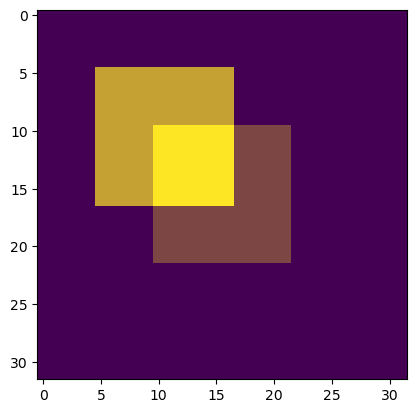

In [9]:
# generate some test objects
A = np.zeros((32, 32))
A[10:-10, 10:-10] = 1
B = np.zeros((32, 32))
B[5:-15, 5:-15] = 1

dice = 2*np.sum(A*B)/(np.sum(A)+np.sum(B))

# display the results
plt.plot()
plt.imshow(A)
plt.imshow(B, alpha=0.7)

print(dice)

<p><font color='#770a0a'>Show that the $F_1$ score, which is the harmonic mean of precision and recall, is equivalent to the Dice similarity coefficient</font><p>

The F1 score is used to compare the performance of two classifiers. For binary segmentation the classses are foreground and background. The ground truth can be described as followed:

| | Predicted foregound | Predicted background |
| --- | --- | --- |
| Actual foreground | 1 | 0 |
| Actual background | 0 | 1 |

The F1 score can be calculated as:
$$F1 = \frac{2(P*R)}{P+R}$$ with P the precision and R the recall which are defined as follows:
$$P = \frac{TP}{TP+FP}$$ and $$R = \frac{TP}{TP+FN}$$
TP is the number of true positives = the predicted outcome is also the actual outcome, where both predicted outcome and actual outcome is foreground.
FP is the number of false positives = the predicted outcome is not the same as the actual outcome, where the predicted outcome is foreground and the actual outcome is background.
FN is the number of false negatives = the predicted outcome is not the same as the actual outcome, where the predicted outcome is is background and the actual outcome is foreground.

Substituting P and R in F1 and rewriting results in:
$$F1 = \frac{2TP}{2TP+FP+FN}$$

Suppose the objects from above:

F1=0.3402777777777778


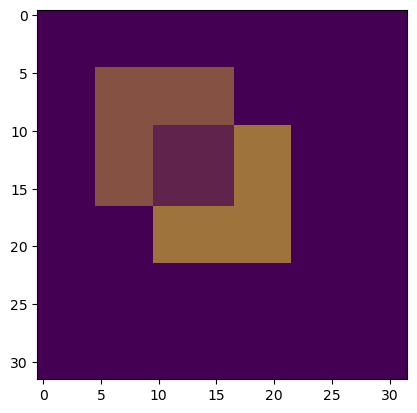

In [10]:
#calculate the areas of the TP, FP and FN
TP_area = np.logical_and(A,B).astype(int)
FP_area = np.logical_and(A==0,B==1).astype(int)
FN_area = np.logical_and(A==1,B==0).astype(int)

#obtain the non_zeros for calculation of F1
TP = np.count_nonzero(TP_area)
FP = np.count_nonzero(FP_area)
FN = np.count_nonzero(FN_area)

F1 = (2*TP)/((2*TP)+FP+FN)
print(f'F1={F1}')

#display the results
plt.plot()
plt.imshow(TP_area)
plt.imshow(FP_area,alpha=0.7)
plt.imshow(FN_area,alpha=0.5)

In the example it is shown that the F1-score == Dice similarity coefficient.